# BBC News Classification

DTSA 5510 Unsupervised Algorithms in Machine Learning

University of Colorado Boulder

In [165]:
# data manipulation
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# modeling & text processing
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD  
from sklearn.feature_selection import chi2
import re


# storage
from scipy.sparse import save_npz
import pickle

In [166]:
# load train and test data
test_data = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
train_data = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB

Train Data Shape: (1490, 3)

Test Data Shape: (735, 2)

Training Data Head:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

Missing values in training Set:
ArticleId    0
Text         0
Category     0
dtype: int64

Missing Values

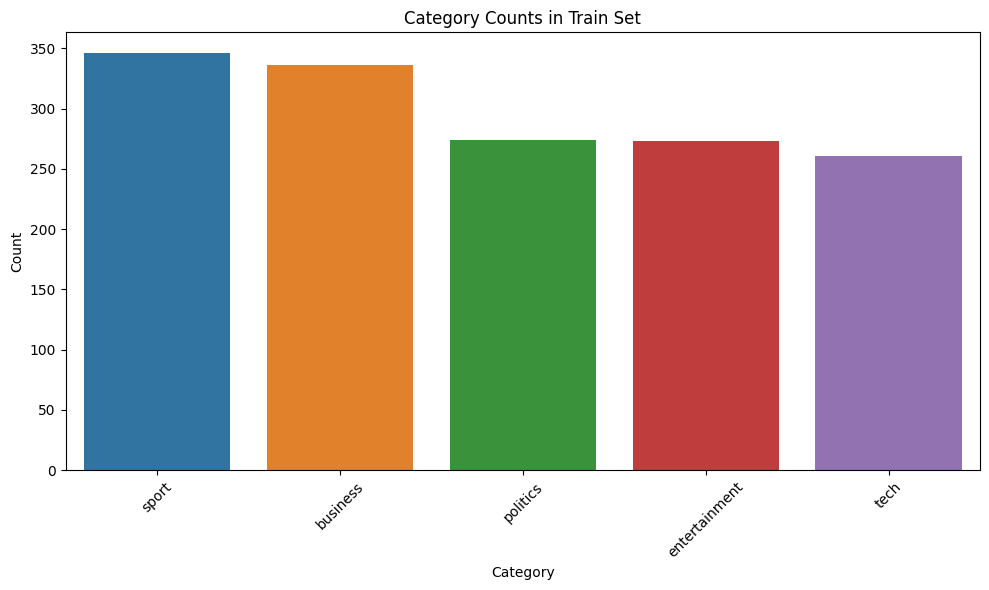

In [157]:
# data exploration
def explore_data():
    
    print('\nTraining Data Info:')
    train_data.info()
    
    print('\nTrain Data Shape:', train_data.shape)
    print('\nTest Data Shape:', test_data.shape)
    
    print('\nTraining Data Head:')
    print(train_data.head())
    
    print("\nMissing values in training Set:")
    print(train_data.isnull().sum())
    print("\nMissing Values in Test Set:")
    print(train_data.isnull().sum())
    
    print("\nCategory Counts in Train Set:")
    print(train_data['Category'].value_counts())
    
    print("\nText statistics by category:")
    texts_by_category = train_data.groupby('Category')['Text'].apply(list)
    category_stats = {}
    
    for category, texts in texts_by_category.items():
        combined_text = ' '.join(texts)
        
        all_words = combined_text.lower().split()
        total_words = len(all_words)
        unique_words = len(set(all_words))
        
        category_stats[category] = {
            'total_words': total_words,
            'unique_words': unique_words,
            'vocabulary_richness': unique_words / total_words
        }
    
    stats_df = pd.DataFrame.from_dict(category_stats, orient='index')
    print(stats_df)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_counts.index, y=category_counts.values)
    plt.title('Category Counts in Train Set')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()

explore_data()

## Data Preprocessing

In [152]:
# data preprocessing
def custom_tokenizer(text):

    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    
    stemmer = PorterStemmer()
    stems = [stemmer.stem(word) for word in words]
    return stems

stop_words = [custom_tokenizer(word)[0] for word in stopwords.words('english')]

tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, stop_words=stop_words)

tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_data['Text'])

tfidf_matrix_test = tfidf_vectorizer.transform(test_data['Text'])

svd = TruncatedSVD(n_components=2)
tfidf_SVD_train = svd.fit_transform(tfidf_matrix_train)

## Further Data Exploration

In [148]:
print(f"\nTF-IDF matrix shape: {tfidf_matrix_train.shape}")
print(f"\nNumber of features: {len(tfidf_vectorizer.get_feature_names_out())}")

## Appendix

### Text Statistics by Category Visualization

               total_words  unique_words  vocabulary_richness
business            112281         12841             0.114365
entertainment        91158         12130             0.133066
politics            123215         11495             0.093292
sport               116030         11661             0.100500
tech                130985         12628             0.096408


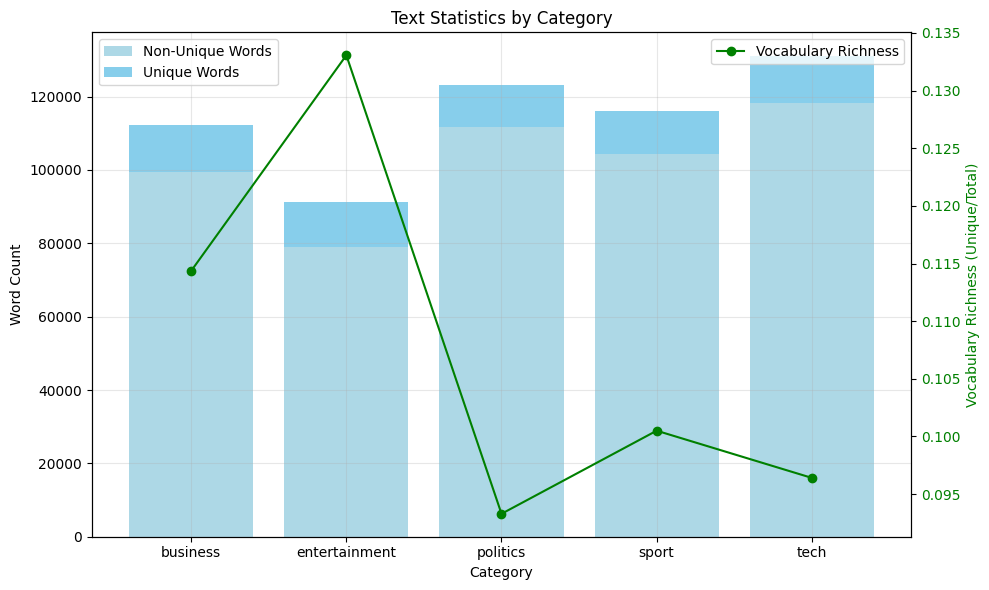

In [162]:
# Text statistics by category
texts_by_category = train_data.groupby('Category')['Text'].apply(list)
category_stats = {}

for category, texts in texts_by_category.items():
    combined_text = ' '.join(texts)
    all_words = combined_text.lower().split()
    total_words = len(all_words)
    unique_words = len(set(all_words))
    category_stats[category] = {
        'total_words': total_words,
        'unique_words': unique_words,
        'vocabulary_richness': unique_words / total_words
    }

stats_df = pd.DataFrame.from_dict(category_stats, orient='index')
print(stats_df)

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

# Stacked bar for total and unique words
stats_df['non_unique_words'] = stats_df['total_words'] - stats_df['unique_words']
ax1.bar(stats_df.index, stats_df['non_unique_words'], label='Non-Unique Words', color='lightblue')
ax1.bar(stats_df.index, stats_df['unique_words'], bottom=stats_df['non_unique_words'], label='Unique Words', color='skyblue')
ax1.set_xlabel('Category')
ax1.set_ylabel('Word Count')
ax1.set_title('Text Statistics by Category')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Secondary axis for vocabulary richness
ax2 = ax1.twinx()
ax2.plot(stats_df.index, stats_df['vocabulary_richness'], color='green', marker='o', label='Vocabulary Richness')
ax2.set_ylabel('Vocabulary Richness (Unique/Total)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

plt.tight_layout()